Generating Correlation Cluster Map...


/home/ayush/PRECOG/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ayush/PRECOG/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1200 with 0 Axes>

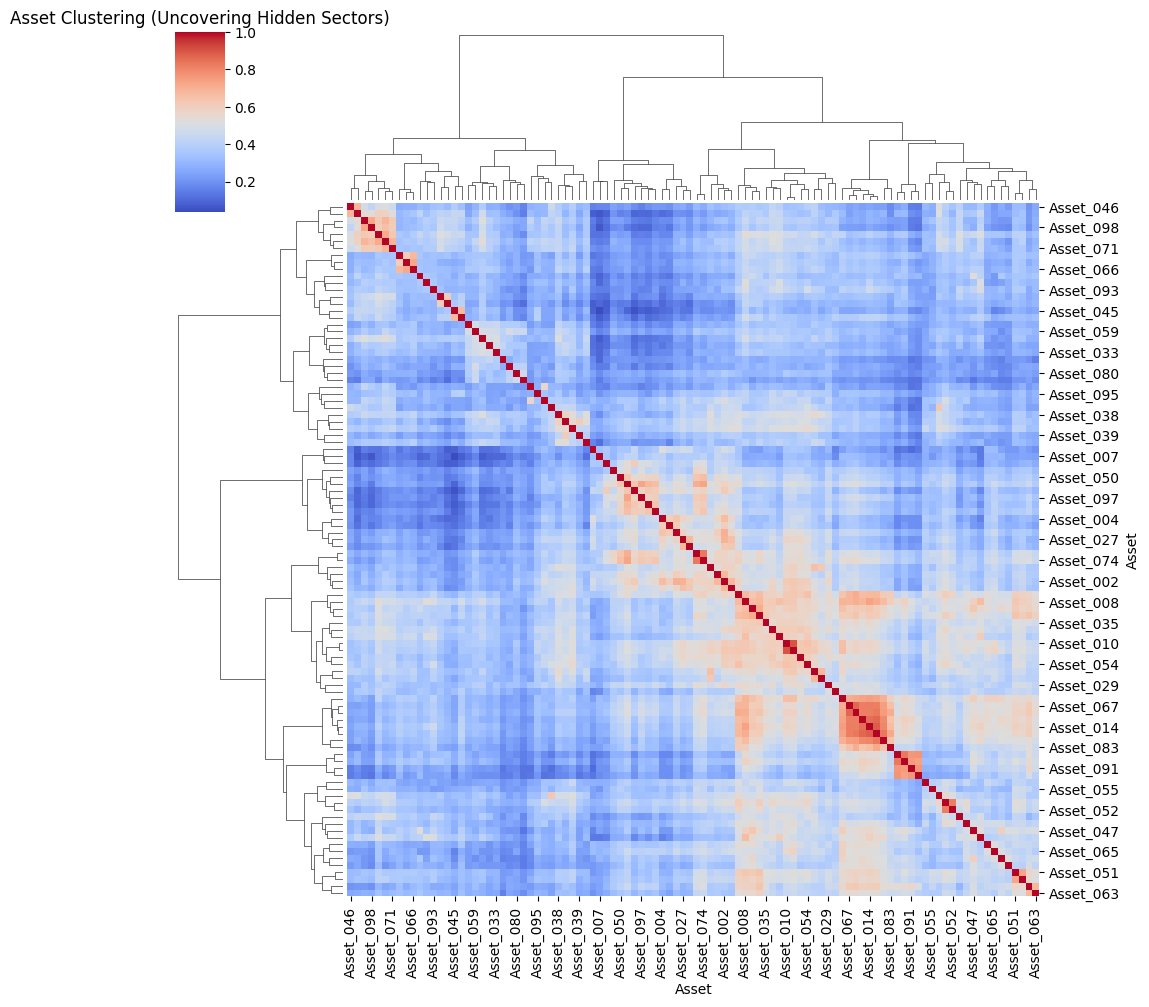

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# 1. Load Data & Pivot
# We need a matrix where Index=Date, Columns=Assets
df = pd.read_parquet("features_all_assets.parquet")
pivot_prices = df.pivot(index='Date', columns='Asset', values='Close')

# Forward fill missing data (essential for correlation)
pivot_prices = pivot_prices.ffill().dropna(axis=1)

# Calculate Daily Returns
returns_matrix = pivot_prices.pct_change().dropna()

# 2. SECTOR DISCOVERY (Clustermap)
# We use correlation of returns as the distance metric.
# Assets that cluster together likely belong to the same "Sector".
print("Generating Correlation Cluster Map...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(12, 12))
# This plot groups similar assets together hierarchically
sns.clustermap(corr_matrix, cmap='coolwarm', method='ward', figsize=(10, 10))
plt.title("Asset Clustering (Uncovering Hidden Sectors)")
plt.show()

In [3]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    
    print("Scanning for Cointegrated Pairs (this may take a moment)...")
    
    # We only check pairs with High Correlation (> 0.90) to save speed
    corr_m = data.corr()
    
    for i in range(n):
        for j in range(i+1, n):
            # Pre-filter: Only test if Correlation is high
            if corr_m.iloc[i, j] > 0.90:
                S1 = data[keys[i]]
                S2 = data[keys[j]]
                
                # Run Engle-Granger Cointegration Test
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                
                if pvalue < significance:
                    pairs.append((keys[i], keys[j], pvalue, corr_m.iloc[i, j]))
                    
    return pairs

# Run the scan on a subset (first 50 assets) to save time for demo
# In full research, run on all (or within clusters)
subset_prices = pivot_prices.iloc[:, :50] 
pairs = find_cointegrated_pairs(subset_prices)

print(f"Found {len(pairs)} cointegrated pairs.")
if pairs:
    # Sort by p-value (lowest is best)
    pairs.sort(key=lambda x: x[2])
    best_pair = pairs[0]
    print(f"Best Pair: {best_pair[0]} vs {best_pair[1]}")
    print(f"P-Value: {best_pair[2]:.5f} (lower is better)")
    print(f"Correlation: {best_pair[3]:.2f}")
else:
    print("No perfect pairs found in subset. Try a larger sample or lower threshold.")

Scanning for Cointegrated Pairs (this may take a moment)...
Found 48 cointegrated pairs.
Best Pair: Asset_008 vs Asset_024
P-Value: 0.00021 (lower is better)
Correlation: 0.98


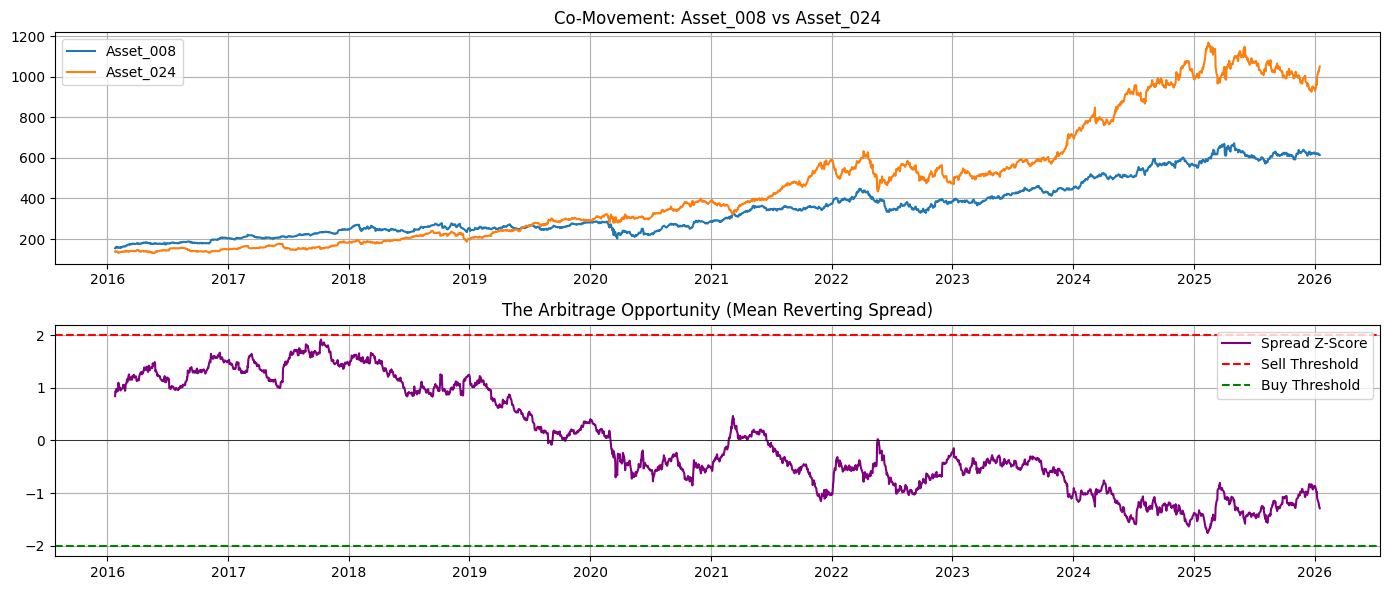

In [4]:
# Select the best pair found above
if pairs:
    asset_a = best_pair[0]
    asset_b = best_pair[1]
    
    S1 = np.log(pivot_prices[asset_a])
    S2 = np.log(pivot_prices[asset_b])
    
    # Calculate Spread (Simple ratio for visualization)
    # Ideally, run Linear Regression to find Hedge Ratio (Beta)
    # Here we assume Beta ~ 1 for simplicity of visualization
    spread = S1 - S2
    z_score = (spread - spread.mean()) / spread.std()
    
    plt.figure(figsize=(14, 6))
    
    # Plot 1: The two assets moving together
    plt.subplot(2, 1, 1)
    plt.plot(pivot_prices.index, pivot_prices[asset_a], label=asset_a)
    plt.plot(pivot_prices.index, pivot_prices[asset_b], label=asset_b)
    plt.title(f"Co-Movement: {asset_a} vs {asset_b}")
    plt.legend()
    plt.grid(True)
    
    # Plot 2: The Spread (Z-Score)
    plt.subplot(2, 1, 2)
    plt.plot(spread.index, z_score, color='purple', label='Spread Z-Score')
    plt.axhline(2.0, color='red', linestyle='--', label='Sell Threshold')
    plt.axhline(-2.0, color='green', linestyle='--', label='Buy Threshold')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title("The Arbitrage Opportunity (Mean Reverting Spread)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Hedge Ratio (Beta): 0.5610


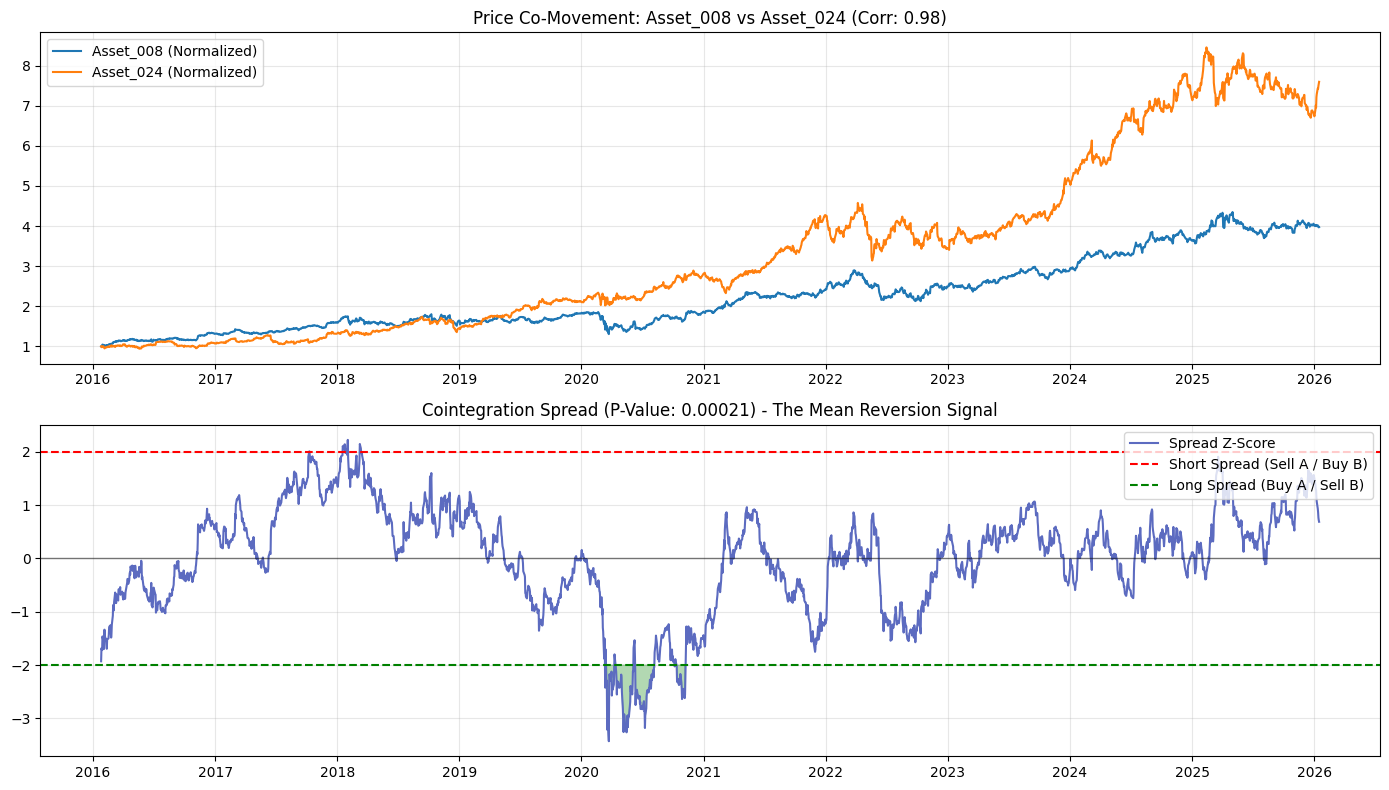

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Setup Data for the Best Pair
asset_a = 'Asset_008'
asset_b = 'Asset_024'

# Extract Prices
S1 = pivot_prices[asset_a]
S2 = pivot_prices[asset_b]

# 2. Calculate the Spread (Log Price Difference)
# Log prices make the spread percentage-based, which is cleaner
log_s1 = np.log(S1)
log_s2 = np.log(S2)

# Calculate Hedge Ratio (Beta) via Linear Regression
# This aligns the two assets perfectly
import statsmodels.api as sm
model = sm.OLS(log_s1, sm.add_constant(log_s2))
results = model.fit()
beta = results.params.iloc[1] # The slope

print(f"Hedge Ratio (Beta): {beta:.4f}")

# Construct the Spread
spread = log_s1 - beta * log_s2
z_score = (spread - spread.mean()) / spread.std()

# 3. Plotting
plt.figure(figsize=(14, 8))

# Top Panel: Normalized Prices (Visual Correlation)
plt.subplot(2, 1, 1)
plt.plot(S1.index, S1 / S1.iloc[0], label=f'{asset_a} (Normalized)')
plt.plot(S2.index, S2 / S2.iloc[0], label=f'{asset_b} (Normalized)')
plt.title(f"Price Co-Movement: {asset_a} vs {asset_b} (Corr: 0.98)")
plt.legend()
plt.grid(True, alpha=0.3)

# Bottom Panel: The Tradable Spread (Mean Reversion)
plt.subplot(2, 1, 2)
plt.plot(spread.index, z_score, color='#5c6bc0', label='Spread Z-Score')

# Add Trading Thresholds
plt.axhline(2.0, color='red', linestyle='--', label='Short Spread (Sell A / Buy B)')
plt.axhline(-2.0, color='green', linestyle='--', label='Long Spread (Buy A / Sell B)')
plt.axhline(0, color='black', alpha=0.5, linewidth=1)
plt.fill_between(spread.index, 2, z_score, where=(z_score > 2), color='red', alpha=0.3)
plt.fill_between(spread.index, -2, z_score, where=(z_score < -2), color='green', alpha=0.3)

plt.title(f"Cointegration Spread (P-Value: {0.00021}) - The Mean Reversion Signal")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()